## defining arch

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1)  # 512 -> 256
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)  # 256 -> 128
        # self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)  # 128 -> 64
        # self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)  # 64 -> 32
        # self.flatten = nn.Flatten()
        # self.fc1 = nn.Linear(128 * 32 * 32, 1024)  # Fully connected layer
        # self.fc2 = nn.Linear(1024, 256)  # Fully connected layer

    def forward(self, x):
        x = torch.relu(self.conv1(x))  # 512 -> 256
        x = torch.relu(self.conv2(x))  # 256 -> 128
        # x = torch.tanh(self.conv3(x))  # 128 -> 64
        # x = torch.tanh(self.conv4(x))  # 64 -> 32
        # x = self.flatten(x)
        # x = torch.tanh(self.fc1(x))  # Fully connected layer
        # x = torch.tanh(self.fc2(x))  # Fully connected layer
        return x  # Final compressed representation


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # self.fc1 = nn.Linear(256, 1024)
        # self.fc2 = nn.Linear(1024, 128 * 32 * 32)
        # self.unflatten = nn.Unflatten(1, (128, 32, 32))
        # self.convt1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)  # 32 -> 64
        # self.convt2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)  # 64 -> 128
        self.convt3 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1)  # 128 -> 256
        self.convt4 = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1)  # 256 -> 512

        # Additional outputs for intermediate resolutions
        self.out_128 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=1)  # Output at 128x128
        self.out_256 = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=1)  # Output at 256x256

    def forward(self, x):
        # x = torch.tanh(self.fc1(x))  # Fully connected layer
        # x = torch.tanh(self.fc2(x))  # Fully connected layer
        # x = self.unflatten(x)
        # x = torch.tanh(self.convt1(x))  # 32 -> 64
        # x = torch.tanh(self.convt2(x))  # 64 -> 128

        out_128 = torch.tanh(self.out_128(x))  # 128x128 output

        x = torch.relu(self.convt3(x))  # 128 -> 256
        out_256 = torch.tanh(self.out_256(x))  # 256x256 output

        x = torch.relu(self.convt4(x))  # 256 -> 512
        out_512 = torch.tanh(x)  # 512x512 output

        return out_128, out_256, out_512


class AutoEncoderMRL(nn.Module):
    def __init__(self):
        super(AutoEncoderMRL, self).__init__()
        self.encoder = Encoder()  # Downsampling: 512 -> 32
        self.decoder = Decoder()  # Upsampling: 32 -> 512

    def forward(self, x):
        emb = self.encoder(x)  # Get compressed representation
        out_128, out_256, out_512 = self.decoder(emb)  # Reconstruct at multiple resolutions
        return out_128, out_256, out_512, emb


In [2]:
from torchmetrics.functional import peak_signal_noise_ratio as psnr

def mrl_loss(outputs, target_128, target_256, target_512, weights):
    """
    Compute the MRL loss as a weighted sum of PSNR losses for 128x128, 256x256, and 512x512 resolutions.

    :param out_128: Reconstructed output at 128x128.
    :param out_256: Reconstructed output at 256x256.
    :param out_512: Reconstructed output at 512x512.
    :param target_128: Ground truth image at 128x128.
    :param target_256: Ground truth image at 256x256.
    :param target_512: Ground truth image at 512x512.
    :param weights: List of weights for each resolution [w_128, w_256, w_512].
    :return: Combined loss value.
    """
    out_128, out_256, out_512 = outputs
    loss_128 = -psnr(out_128, target_128, data_range=1.0)
    loss_256 = -psnr(out_256, target_256, data_range=1.0)
    loss_512 = -psnr(out_512, target_512, data_range=1.0)

    # print(f"PSNR Loss at 128x128: {-loss_128:.4f}, 256x256: {-loss_256:.4f}, 512x512: {-loss_512:.4f}")

    # Weighted sum of losses
    total_loss = weights[0] * loss_128 + weights[1] * loss_256 + weights[2] * loss_512
    return loss_128 , loss_256 , loss_512 , total_loss / 3  


/home/hardik/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Custom Dataset for loading images from a single folder
class ImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        # Sort image files to ensure consistent order
        self.image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_path)  # Open the image
        if self.transform:
            image = self.transform(image)
        return image  # Return the transformed image


# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),          # Convert image to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Folder paths for different resolutions
folder_path_512 = 'data/train/512'
folder_path_256 = 'data/train/256'
folder_path_128 = 'data/train/128'

# Create datasets for each resolution
dataset_512 = ImageDataset(folder_path_512, transform=transform)
dataset_256 = ImageDataset(folder_path_256, transform=transform)
dataset_128 = ImageDataset(folder_path_128, transform=transform)

# Define dataloaders
batch_size = 32
dataloader_512 = DataLoader(dataset_512, batch_size=batch_size, shuffle=False)
dataloader_256 = DataLoader(dataset_256, batch_size=batch_size, shuffle=False)
dataloader_128 = DataLoader(dataset_128, batch_size=batch_size, shuffle=False)


torch.Size([8, 3, 512, 512])


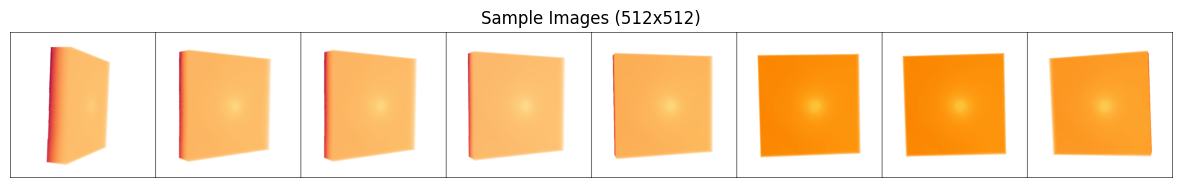

torch.Size([8, 3, 256, 256])


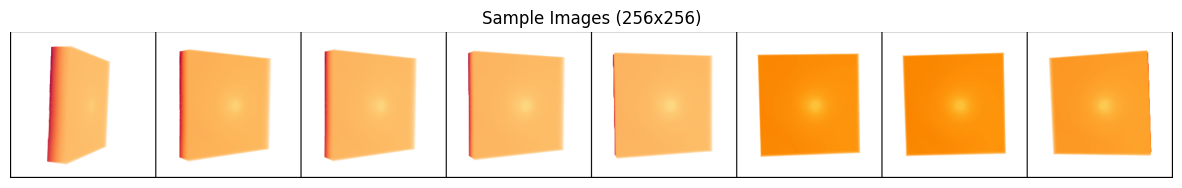

torch.Size([8, 3, 128, 128])


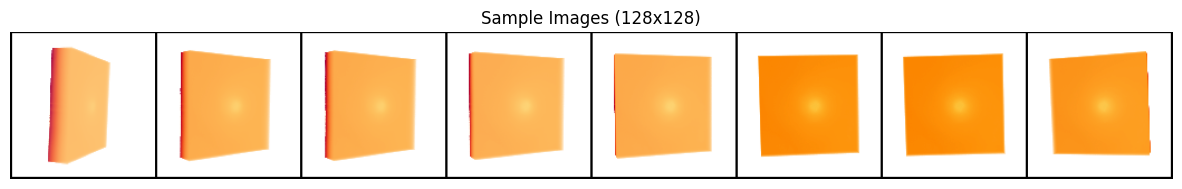

In [4]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def visualize_images(dataloader, title, num_images=8):
    """
    Visualize a batch of images from the specified DataLoader.

    :param dataloader: DataLoader object
    :param title: Title for the plot
    :param num_images: Number of images to visualize
    """
    # Get a batch of images
    images = next(iter(dataloader))[:num_images]

    # Make a grid of images
    grid = vutils.make_grid(images, nrow=num_images, normalize=True, scale_each=True)
    print(images.shape)
    # Convert to NumPy for plotting
    grid_np = grid.cpu().numpy().transpose(1, 2, 0)  # CxHxW -> HxWxC

    # Plot the grid
    plt.figure(figsize=(15, 5))
    plt.imshow(grid_np)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Visualize each resolution
visualize_images(dataloader_512, "Sample Images (512x512)")
visualize_images(dataloader_256, "Sample Images (256x256)")
visualize_images(dataloader_128, "Sample Images (128x128)")


## dataset gen

In [2]:
import os

def check_image_names(folder_path_512, folder_path_256, folder_path_128):
    # Get image file names from each folder
    images_512 = set([f for f in os.listdir(folder_path_512) if f.endswith(('.png', '.jpg', '.jpeg'))])
    images_256 = set([f for f in os.listdir(folder_path_256) if f.endswith(('.png', '.jpg', '.jpeg'))])
    images_128 = set([f for f in os.listdir(folder_path_128) if f.endswith(('.png', '.jpg', '.jpeg'))])

    # Check if all sets are equal
    if images_512 == images_256 == images_128:
        print("All folders contain images with the same names.")
    else:
        print("Folders contain images with different names.")
        print(f"Images in 512 but not in 256: {len(images_512 - images_256)}")
        print(f"Images in 512 but not in 128: {len(images_512 - images_128)}")
        print(f"Images in 256 but not in 512: {len(images_256 - images_512)}")
        print(f"Images in 256 but not in 128: {len(images_256 - images_128)}")
        print(f"Images in 128 but not in 512: {len(images_128 - images_512)}")
        print(f"Images in 128 but not in 256: {len(images_128 - images_256)}")

# Check if all folders contain images with the same names
check_image_names("data/train_new/512", "data/train_new/256", "data/train_new/128")

All folders contain images with the same names.


In [1]:
import shutil
import random
import os
folder_path_512="data/512"
folder_path_256="data/256"
folder_path_128="data/128"
image_names = [f for f in os.listdir(folder_path_512) if f.endswith(('.png', '.jpg', '.jpeg'))]

random.shuffle(image_names)

train_images = image_names[:700]
test_images = image_names[700:]

os.makedirs('data/train_new/512', exist_ok=True)
os.makedirs('data/test_new/512', exist_ok=True)
os.makedirs('data/train_new/256', exist_ok=True)
os.makedirs('data/test_new/256', exist_ok=True)
os.makedirs('data/train_new/128', exist_ok=True)
os.makedirs('data/test_new/128', exist_ok=True)

for img in train_images:
    shutil.move(os.path.join(folder_path_512, img), 'data/train_new/512')
for img in test_images:
    shutil.move(os.path.join(folder_path_512, img), 'data/test_new/512')

for img in train_images:
    shutil.move(os.path.join(folder_path_256, img), 'data/train_new/256')
    shutil.move(os.path.join(folder_path_128, img), 'data/train_new/128')
for img in test_images:
    shutil.move(os.path.join(folder_path_256, img), 'data/test_new/256')
    shutil.move(os.path.join(folder_path_128, img), 'data/test_new/128')

## autoencoder_mrl


In [10]:
# Training loop for the new dataset and updated architecture
from torch.optim import Adam
num_epochs = 10
mrl_weights = [1, 1, 1] 
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device = torch.device('cuda')
autoencoder_mrl = AutoEncoderMRL().to(device)

optimizer = Adam(autoencoder_mrl.parameters(), lr=1e-3)
for epoch in range(num_epochs):
    autoencoder_mrl.train()  # Set model to training mode
    total_loss = 0
    total_loss_128 = 0
    total_loss_256 = 0
    total_loss_512 = 0

    for batch_idx, (images_512, images_256, images_128) in enumerate(zip(dataloader_512, dataloader_256, dataloader_128)):
        images_512 = images_512.to(device)  #
        images_256 = images_256.to(device)  
        images_128 = images_128.to(device)  

        # Forward pass through the autoencoder
        out_128, out_256, out_512, _ = autoencoder_mrl(images_512)


        loss_128 , loss_256 , loss_512 , loss = mrl_loss((out_128, out_256, out_512), images_128, images_256, images_512, mrl_weights)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_loss_128 += loss_128.item()
        total_loss_256 += loss_256.item()
        total_loss_512 += loss_512.item()

    avg_loss = total_loss / len(dataloader_512)
    avg_loss_128 = total_loss_128 / len(dataloader_512)
    avg_loss_256 = total_loss_256 / len(dataloader_512)
    avg_loss_512 = total_loss_512 / len(dataloader_512)
    print(f"Epoch [{epoch+1}/{num_epochs}]: Total Loss: {avg_loss:.4f} | 128x128 Loss: {avg_loss_128:.4f} | 256x256 Loss: {avg_loss_256:.4f} | 512x512 Loss: {avg_loss_512:.4f}")


/home/hardik/.local/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `peak_signal_noise_ratio` from `torchmetrics.image` instead.
  _future_warning(


Epoch [1/10]: Total Loss: -17.9082 | 128x128 Loss: -25.0519 | 256x256 Loss: -21.2357 | 512x512 Loss: -7.4370
Epoch [2/10]: Total Loss: -27.2910 | 128x128 Loss: -35.3961 | 256x256 Loss: -33.4552 | 512x512 Loss: -13.0216
Epoch [3/10]: Total Loss: -30.4423 | 128x128 Loss: -36.8131 | 256x256 Loss: -35.2476 | 512x512 Loss: -19.2660
Epoch [4/10]: Total Loss: -30.9614 | 128x128 Loss: -37.4638 | 256x256 Loss: -36.0849 | 512x512 Loss: -19.3355
Epoch [5/10]: Total Loss: -31.2234 | 128x128 Loss: -37.7553 | 256x256 Loss: -36.5513 | 512x512 Loss: -19.3636
Epoch [6/10]: Total Loss: -31.4534 | 128x128 Loss: -38.0743 | 256x256 Loss: -36.9048 | 512x512 Loss: -19.3811
Epoch [7/10]: Total Loss: -31.6538 | 128x128 Loss: -38.3594 | 256x256 Loss: -37.2071 | 512x512 Loss: -19.3948
Epoch [8/10]: Total Loss: -31.8665 | 128x128 Loss: -38.6288 | 256x256 Loss: -37.5648 | 512x512 Loss: -19.4059
Epoch [9/10]: Total Loss: -31.8613 | 128x128 Loss: -38.6204 | 256x256 Loss: -37.5529 | 512x512 Loss: -19.4105
Epoch [10/1

In [19]:
torch.save(autoencoder_mrl,'autoencoder_model.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.73056895..0.7615739].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.87018234..0.99928874].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.82158047..0.99895626].
/tmp/ipykernel_23174/2618703567.py:87: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of o

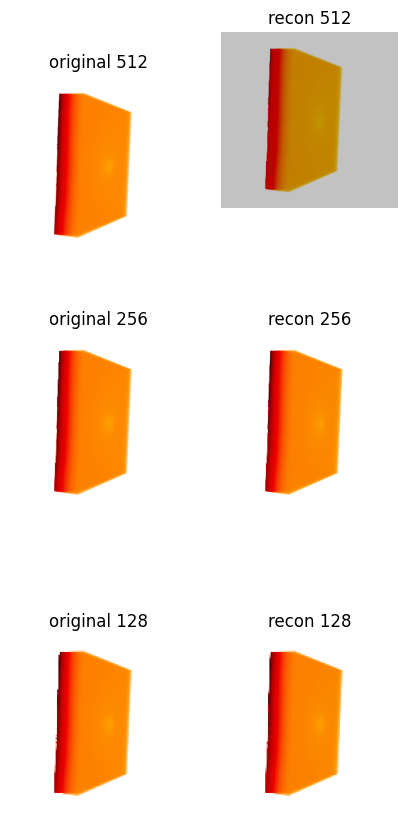

In [24]:
import matplotlib.pyplot as plt

# Set model to evaluation mode
autoencoder_mrl.eval()

img_512 = next(iter(dataloader_512)).to(device)
img_256 = next(iter(dataloader_256)).to(device)
img_128 = next(iter(dataloader_128)).to(device)
# images = images.to(device)

with torch.no_grad():
    out_128, out_256, out_512, _ = autoencoder_mrl(img_512)

img_512 = img_512.cpu().numpy()
img_256 = img_256.cpu().numpy()
img_128 = img_128.cpu().numpy()
out_128 = out_128.cpu().numpy()
out_256 = out_256.cpu().numpy()
out_512 = out_512.cpu().numpy()

# # Function to denormalize images (from [-1, 1] to [0, 1])
# def denormalize(tensor):
#     return (tensor * 0.5) + 0.5

# # Denormalize the images and outputs
# # images = denormalize(images)  # Original images
# out_128 = denormalize(out_128)  # Reconstructed 128x128
# out_256 = denormalize(out_256)  # Reconstructed 256x256
# out_512 = denormalize(out_512)  # Reconstructed 512x512

plt.figure(figsize=(5, 15))

plt.subplot(3,2,1)
plt.imshow(img_512[0].transpose(1,2,0))
plt.title("original 512")
plt.axis("off")

plt.subplot(4,2,2)
plt.imshow(out_512[0].transpose(1,2,0))
plt.title("recon 512")
plt.axis("off")

plt.subplot(4,2,3)
plt.imshow(img_256[0].transpose(1,2,0))
plt.title("original 256")
plt.axis("off")

plt.subplot(4,2,4)
plt.imshow(out_256[0].transpose(1,2,0))
plt.title("recon 256")
plt.axis("off")

plt.subplot(4,2,5)
plt.imshow(img_128[0].transpose(1,2,0))
plt.title("original 128")
plt.axis("off")

plt.subplot(4,2,6)
plt.imshow(out_128[0].transpose(1,2,0))
plt.title("recon 128")
plt.axis("off")

plt.tight_layout()
plt.show()


In [26]:
autoencoder_mrl.eval()
total_loss = 0

dataset_test_512 = ImageDataset("data/test/512", transform=transform)
dataset_test_256 = ImageDataset("data/test/256", transform=transform) 
dataset_test_128 = ImageDataset("data/test/128", transform=transform) 
batch_size = 32
dataloader_test_512 = DataLoader(dataset_test_512, batch_size=batch_size, shuffle=False)
dataloader_test_256 = DataLoader(dataset_test_256, batch_size=batch_size, shuffle=False)
dataloader_test_128 = DataLoader(dataset_test_128, batch_size=batch_size, shuffle=False)

mrl_weights = [1,1,1]
total_loss = 0
total_loss_128 = 0
total_loss_256 = 0
total_loss_512 = 0
with torch.no_grad():
    for batch_idx, (images_512, images_256, images_128) in enumerate(zip(dataloader_test_512, dataloader_test_256, dataloader_test_128)):
        images_512 = images_512.to(device)  # 512x512 images
        images_256 = images_256.to(device)  # 256x256 images
        images_128 = images_128.to(device)  # 128x128 images

        out_128, out_256, out_512, _ = autoencoder_mrl(images_512)

        loss_128 , loss_256 , loss_512 , loss = mrl_loss((out_128, out_256, out_512), images_128, images_256, images_512, mrl_weights)

        total_loss += loss.item()
        total_loss_128 += loss_128.item()
        total_loss_256 += loss_256.item()
        total_loss_512 += loss_512.item()

# Compute and print the average loss for the epoch
avg_loss = total_loss / len(dataloader_test_512)
avg_loss_128 = total_loss_128 / len(dataloader_test_512)
avg_loss_256 = total_loss_256 / len(dataloader_test_512)
avg_loss_512 = total_loss_512 / len(dataloader_test_512)

print(f"Total Loss: {avg_loss:.4f} | 128x128 Loss: {avg_loss_128:.4f} | 256x256 Loss: {avg_loss_256:.4f} | 512x512 Loss: {avg_loss_512:.4f}")


/home/hardik/.local/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `peak_signal_noise_ratio` from `torchmetrics.image` instead.
  _future_warning(


Total Loss: -29.1962 | 128x128 Loss: -37.5361 | 256x256 Loss: -36.5804 | 512x512 Loss: -13.4722


## autoencoder simple

In [8]:
from torch.optim import Adam
device = torch.device('cpu')
autoencoder_simple = AutoEncoderMRL().to(device)

optimizer = Adam(autoencoder_simple.parameters(), lr=1e-3)

def psnr_loss(output, target):
    mse = F.mse_loss(output, target, reduction='mean')
    psnr = -10 * torch.log10(mse + 1e-8)  # Adding small epsilon to avoid log(0)
    return -psnr  

num_epochs = 10
for epoch in range(num_epochs):
    autoencoder_simple.train()  
    total_loss = 0

    for images_512 in dataloader_512:
        images_512 = images_512.to(device)

        _, _, out_512, _ = autoencoder_simple(images_512)

        loss = psnr_loss(out_512, images_512)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader_512)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training completed for the simple autoencoder.")


Epoch [1/10], Loss: -10.2607
Epoch [2/10], Loss: -13.2528
Epoch [3/10], Loss: -13.4031
Epoch [4/10], Loss: -13.4597
Epoch [5/10], Loss: -13.4895
Epoch [6/10], Loss: -13.5085
Epoch [7/10], Loss: -13.5218
Epoch [8/10], Loss: -13.5306
Epoch [9/10], Loss: -13.5364
Epoch [10/10], Loss: -13.5410
Training completed for the simple autoencoder.


In [10]:
torch.save(autoencoder_simple,'autoencoder_simple.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7375074..0.7615857].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.715006..0.761586].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7292828..0.7615859].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].
Clipping 

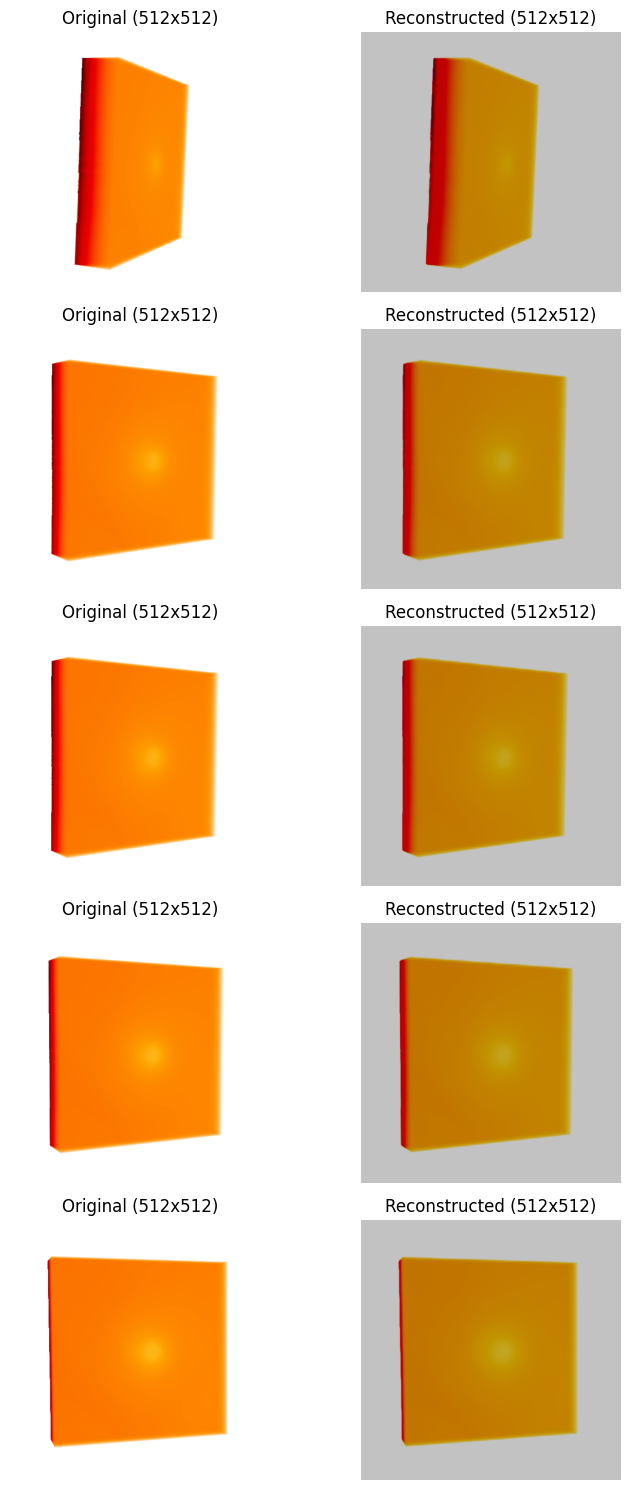

In [13]:
import matplotlib.pyplot as plt
autoencoder_simple.eval()
img = next(iter(dataloader_512)).to(device)

with torch.no_grad():
    _, _, out, _ = autoencoder_simple(img)

img = img.cpu().numpy()
out = out.cpu().numpy()

plt.figure(figsize=(8, 15))
for i in range(5): 
    # Original image
    plt.subplot(5, 2, i * 2 + 1)
    plt.imshow(img[i].transpose(1, 2, 0))
    plt.title("Original (512x512)")
    plt.axis('off')

    # Reconstructed image
    plt.subplot(5, 2, i * 2 + 2)
    plt.imshow(out[i].transpose(1, 2, 0))
    plt.title("Reconstructed (512x512)")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [15]:
autoencoder_simple.eval()
total_loss = 0
def psnr_loss(output, target):
    mse = F.mse_loss(output, target, reduction='mean')
    psnr = -10 * torch.log10(mse + 1e-8)  # Adding small epsilon to avoid log(0)
    return -psnr  # Negative for minimization
dataset_test_512 = ImageDataset("data/test/512", transform=transform)

batch_size = 32
dataloader_test_512 = DataLoader(dataset_test_512, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for images_512 in dataloader_test_512:
        images_512 = images_512.to(device)  # 512x512 images

        _, _, out_512, _ = autoencoder_simple(images_512)

        loss = -psnr(out_512, images_512,data_range=1.0)

        total_loss += loss.item()

avg_loss = total_loss / len(dataloader_test_512)
print(f"Total Loss: {avg_loss:.4f}")


/home/hardik/.local/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `peak_signal_noise_ratio` from `torchmetrics.image` instead.
  _future_warning(


Total Loss: -13.5262
